In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn

from torchvision import transforms
import matplotlib.pyplot as plt

from network import *
from dataloader import *

In [3]:
device = torch.device('cuda')
supervise = ['marked_rgb', 'rgb', 'marker', 'depth', 'pose']
backbone = 'resnet18'
date = '20260118-154203' # '20260127-153431' # '20251128-125750'

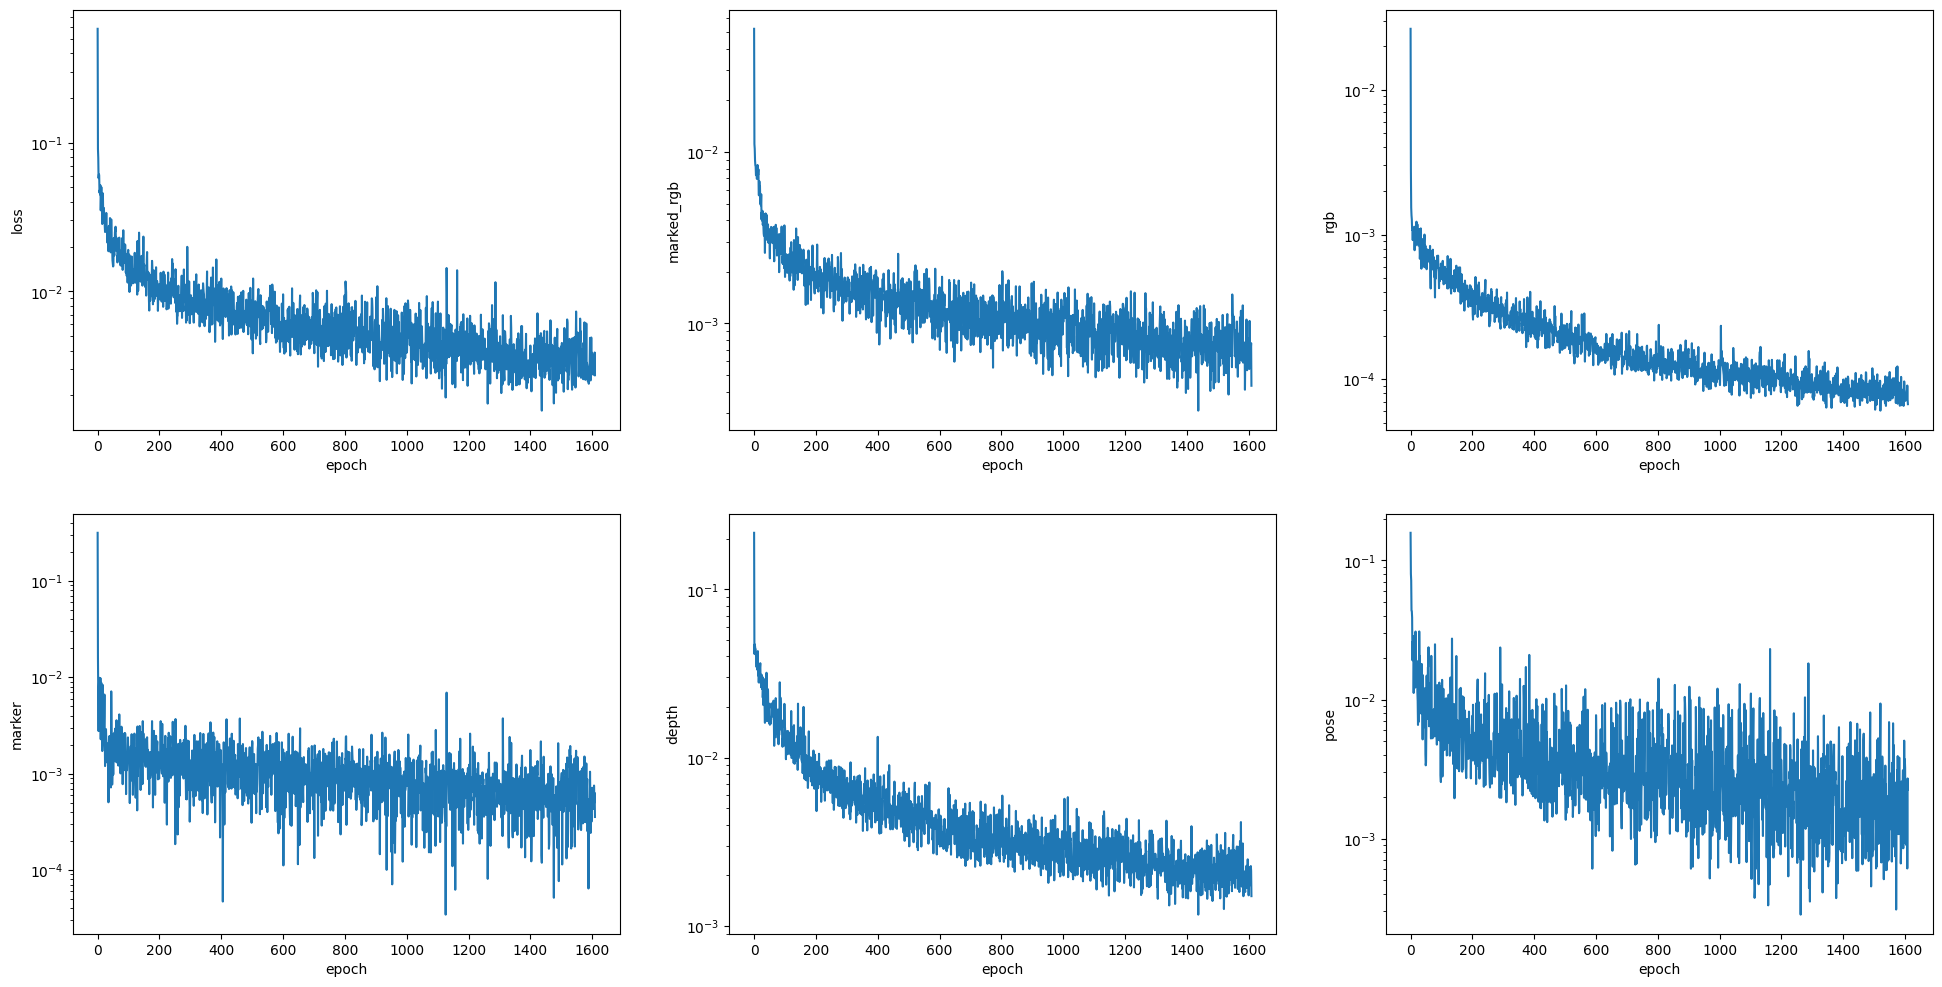

In [4]:
import json
with open(f'./checkpoints/{backbone}/{date}/log.log', 'r') as f:
    logs = [json.loads(line) for line in f.readlines()][1:]

plt.figure(figsize=(24, 12))
plt.subplot(2, 3, 1)
plt.plot([log['loss'] for log in logs if log['status'] == 'train'], label='train_loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')

for i, key in enumerate(supervise):
    plt.subplot(2, 3, i+2)
    plt.plot([log['losses'][key] for log in logs if log['status'] == 'train'], label=f'train_{key}')
    plt.yscale('log')
    plt.xlabel('epoch')
    plt.ylabel(key)

In [5]:
model = Tactile(supervise=supervise, backbone=backbone).to(device)
model.load_state_dict(torch.load(f'./checkpoints/{backbone}/{date}/best.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
import sys
sys.path.append('..')
from envs.utils.transforms import *
from envs.utils.data import HDF5Handler

data = HDF5Handler().load_hdf5('../data/clean/insert_tube/hdf5/0.hdf5')

In [7]:
import numpy as np
from torchvision import transforms

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

n = 8
select_ids = np.random.choice(np.arange(len(data['embodiment']['joint'])), n)
test_data = []
data_dict = {'marked_rgb': [trans(i) for i in data['tactile']['left_gsmini']['rgb_marker'][select_ids]]}
x:torch.Tensor = torch.stack(data_dict['marked_rgb']).to(device)
with torch.no_grad():
    output_dict = model.reconstruct(x)

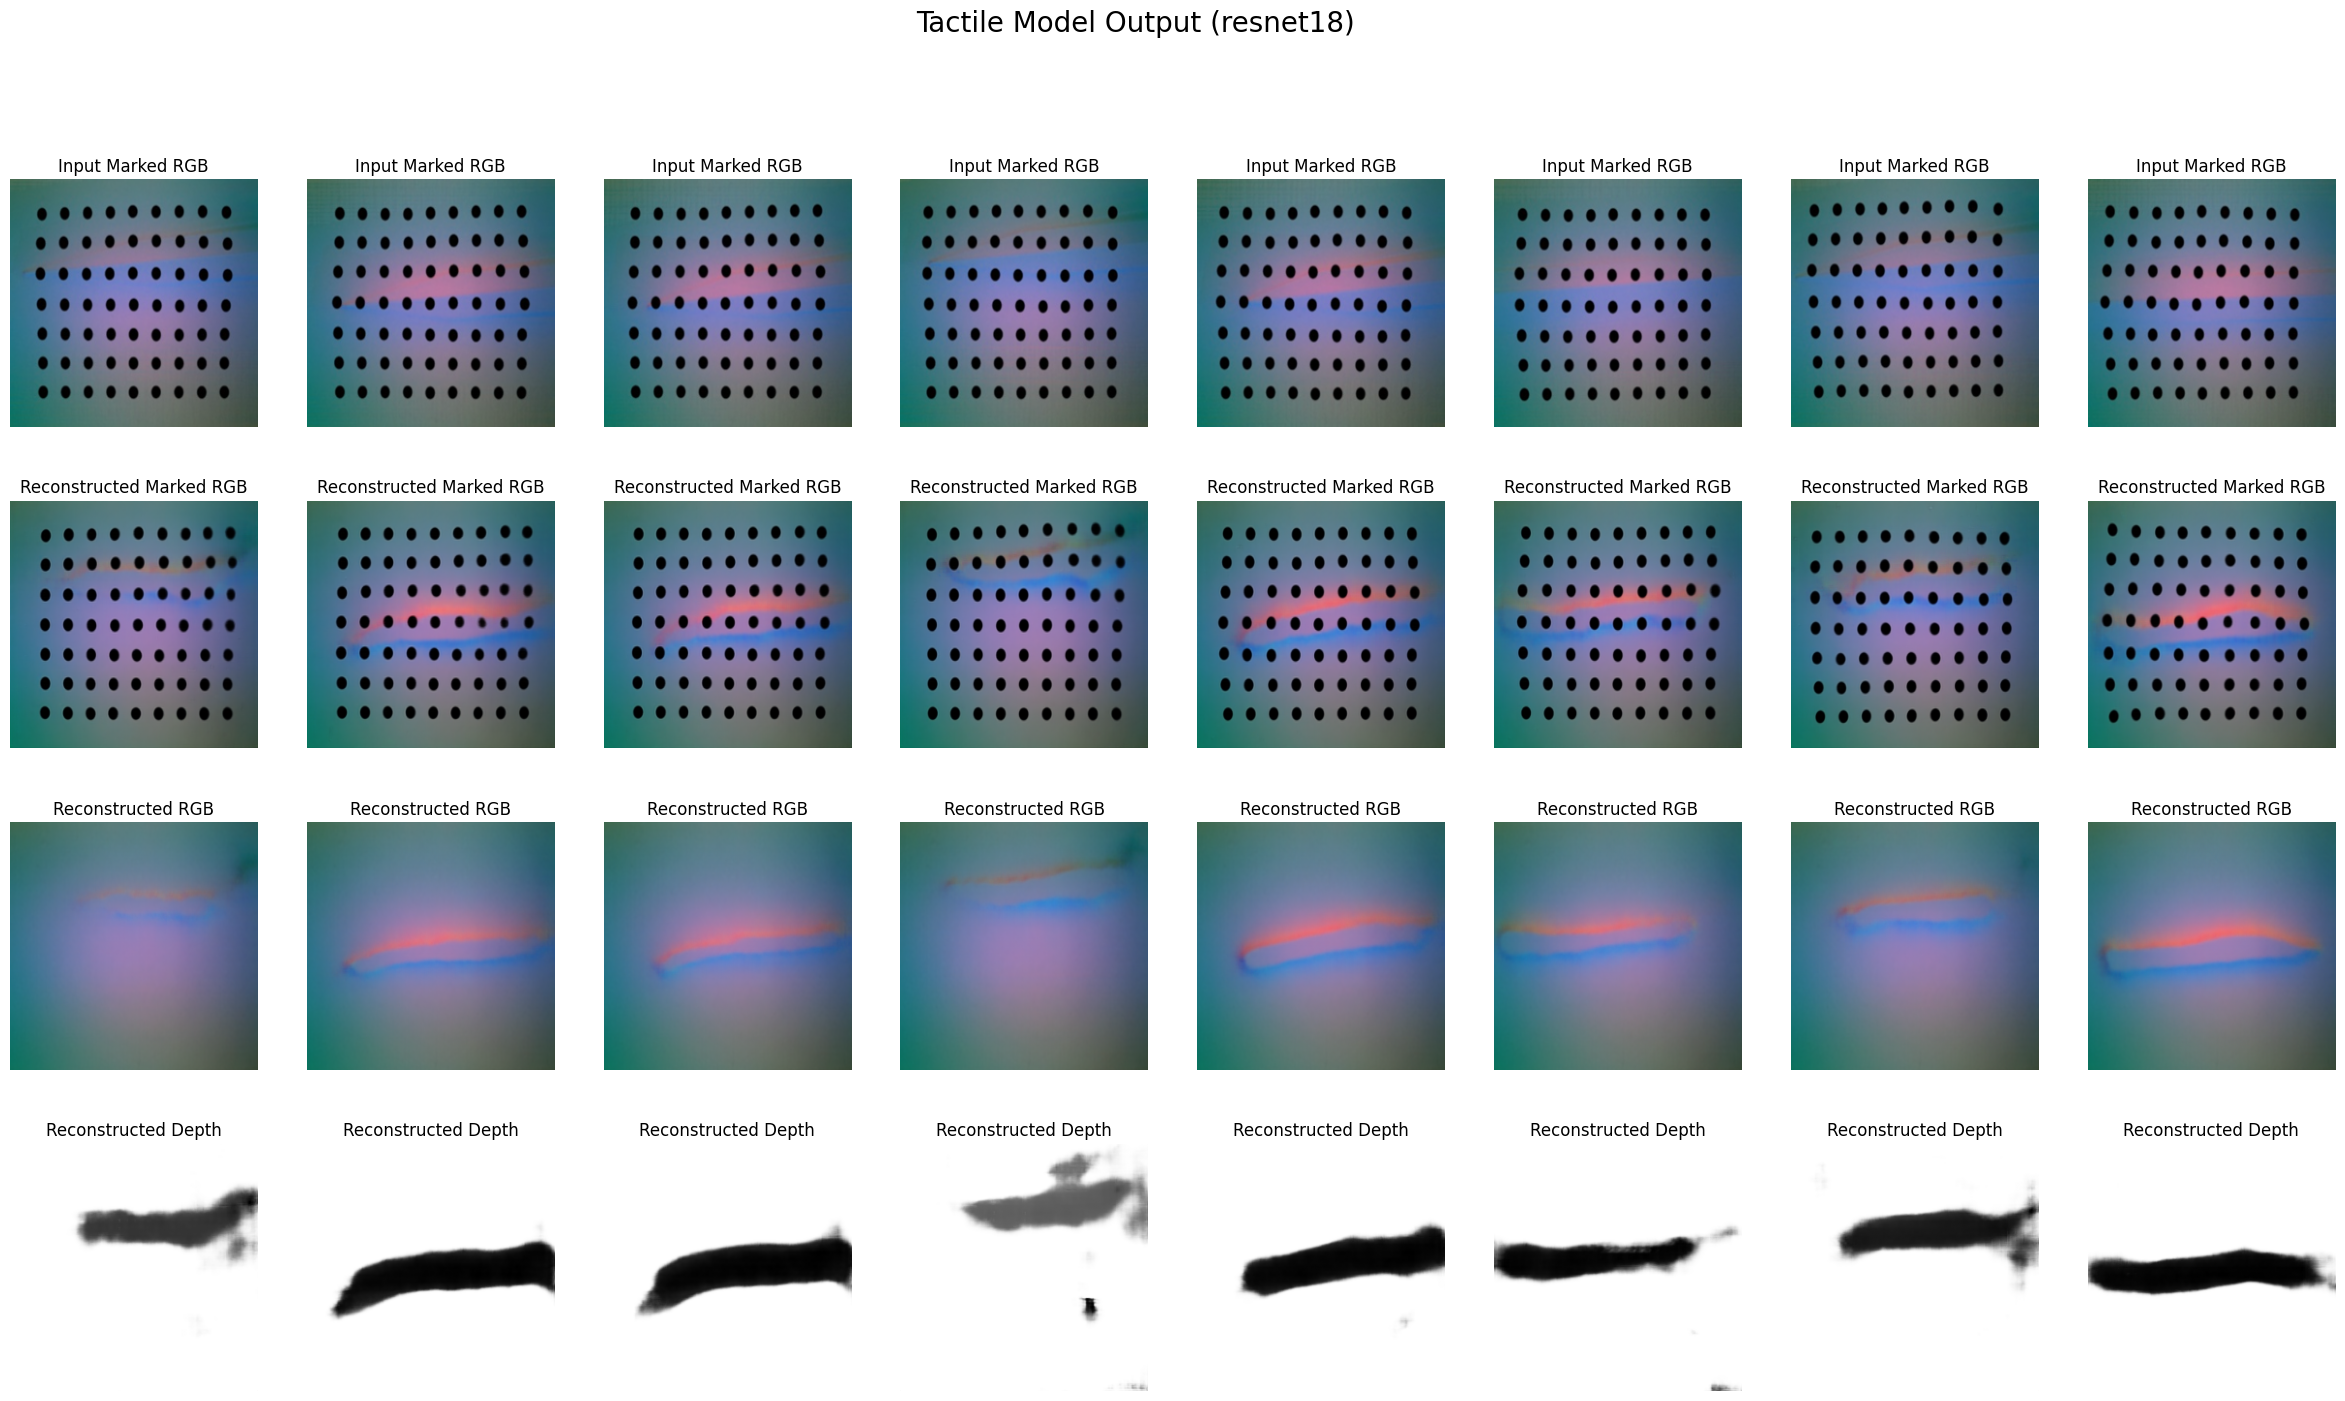

In [8]:
plt.figure(figsize=(30, 16))
m = 4
plt.suptitle(f'Tactile Model Output ({backbone})', fontsize=20)
for i in range(n):
    plt.subplot(m, n, i+1)
    plt.title('Input Marked RGB')
    plt.imshow(x[i].cpu().permute(1,2,0))
    plt.axis('off')
    
    plt.subplot(m, n, n+i+1)
    plt.title('Reconstructed Marked RGB')
    img = output_dict['marked_rgb'][i].permute(1,2,0).cpu().numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(m, n, n*2+i+1)
    plt.title('Reconstructed RGB')
    img = output_dict['rgb'][i].permute(1,2,0).cpu().numpy()
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(m, n, n*3+i+1)
    plt.title('Reconstructed Depth')
    img = output_dict['depth'][i].permute(1,2,0).cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [9]:
prism_names = ['CircleShell', 'Cross', 'Cubehole', 'Cuboid', 'Cylinder', 'Doubleslope', 'Hemisphere', 'Line', 'Pacman', 'S', 'Sphere', 'Star', 'Tetrahedron', 'Torus']
hdf5_paths = []
for name in prism_names:
    hdf5_paths.extend(list(Path(f'../data/contact-gs/{name}/hdf5').glob('*.hdf5'))[10:11])
print(f'Found {len(hdf5_paths)} hdf5 files.')
data = HDF5Dataset(hdf5_paths)
print(f'Dataset length: {len(data)}')
test_loader = DataLoader(
    data, batch_size=8, shuffle=False
)

Found 14 hdf5 files.


Loading HDF5 metadata: 100%|██████████| 14/14 [00:01<00:00,  9.71it/s]

Dataset length: 27634


In [10]:
def check(d):
    print(d['depth'].shape)
    depth = d['depth'][:, 100:-100, 100:-100]
    if depth.min() == depth.max():
        return False
    # left = d['depth'][:, :30, :]
    # right = d['depth'][:, -30:, :]
    # if left.min() != left.max() or right.min() != right.max():
    #     return False
    # return True

select_from_shape = []
for name in prism_names:
    for i, d in enumerate(data._data_metadata):
        if name == str(Path(d['hdf5_path']).parent.parent.stem):
            # if not check(data[i]):
            #     print(f'{i:>5d} <{name}> fail!')
            select_from_shape.append(i)
            break

In [11]:
import numpy as np

n = len(prism_names)
test_data = []
data_dict = {}
for key in supervise:
    data_dict[key] = [
        test_loader.dataset[i][key] for i in select_from_shape
    ]
x:torch.Tensor = torch.stack(data_dict['marked_rgb']).to(device)
with torch.no_grad():
    output_dict = model.reconstruct(x)

[0.06746059656143188, 0.0071809133514761925, 0.04001251608133316, 0.46097150444984436, 0.36242052912712097, -0.35668665170669556, -0.5151466131210327]
[-0.027798902243375778, 0.014241212978959084, 0.039742618799209595, 0.41057267785072327, -0.1096629947423935, 0.13634410500526428, -0.4783570170402527]
[0.08716394007205963, -0.0010744640603661537, 0.03807900846004486, 0.4634159803390503, 0.45718973875045776, -0.47861868143081665, -0.5050463676452637]
[0.07957769930362701, -0.0035988297313451767, 0.04172635078430176, 0.44031065702438354, 0.39613857865333557, -0.4620033800601959, -0.4970153272151947]
[0.0961700975894928, 0.002799456939101219, 0.037446461617946625, 0.47891363501548767, 0.47130051255226135, -0.48250487446784973, -0.5103740692138672]
[0.07779810577630997, 0.0038468679413199425, 0.03968192636966705, 0.4222734868526459, 0.3648034334182739, -0.36899760365486145, -0.4614661633968353]
[0.07943585515022278, 0.005987108219414949, 0.04108450934290886, 0.4190164804458618, 0.366012394

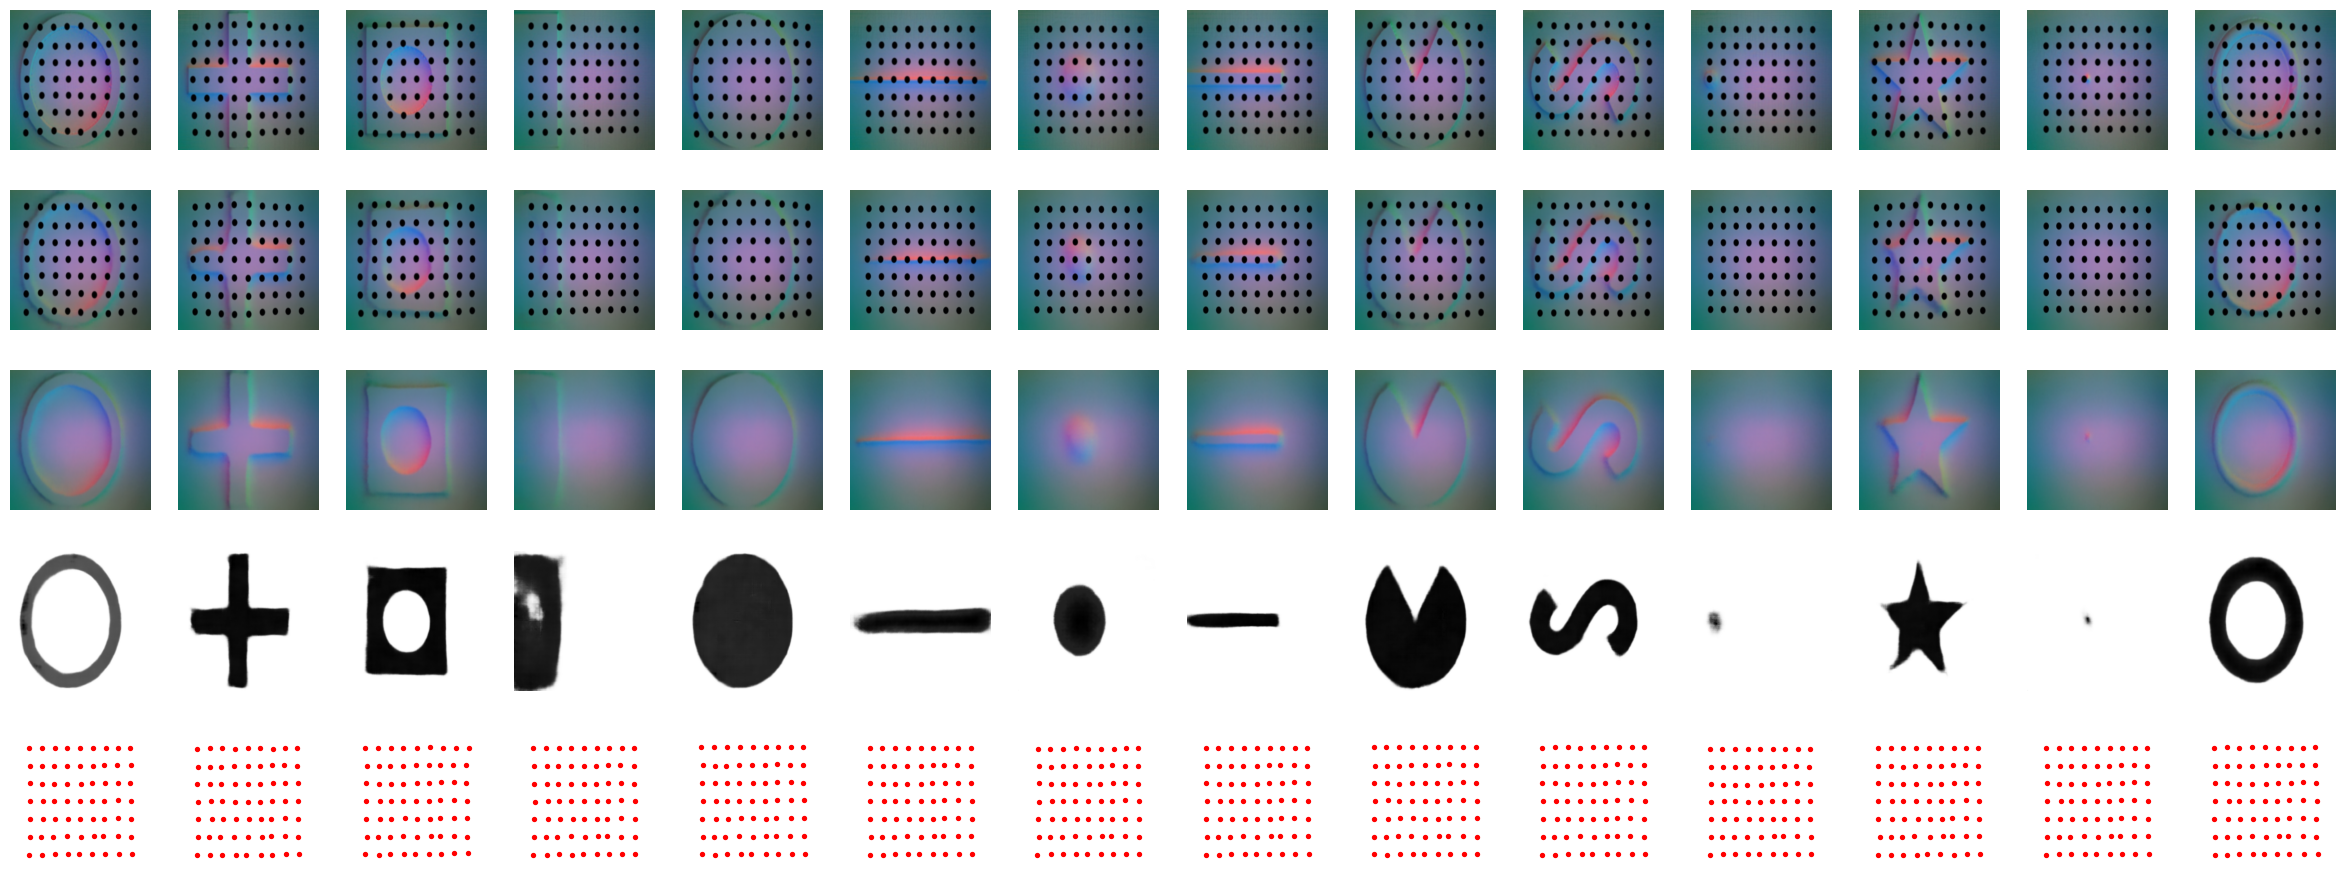

In [17]:
import cv2
import matplotlib.pyplot as plt
import matplotlib

from PIL import Image

# 修改字体为 Times New Roman
# matplotlib.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(30, 16))
plt.style.use('default')
m = len(supervise) + 2
# plt.suptitle(f'Tactile Model Output ({backbone})', fontsize=20)
for i in range(n):
    plt.subplot(m, n, i+1)
    img = x[i].cpu().permute(1,2,0).numpy()
    img = cv2.resize(img, (256, 256))
    Image.fromarray((img * 255).astype(np.uint8)).save(f'./tmp/{i:02d}_raw.png')
    # img = img[..., ::-1]
    plt.imshow(img)
    # plt.title(prism_names[i])
    plt.axis('off')
    
    plt.subplot(m, n, n+i+1)
    img = output_dict['marked_rgb'][i].permute(1,2,0).cpu().numpy()
    Image.fromarray((img * 255).astype(np.uint8)).save(f'./tmp/{i:02d}_recon_marked.png')
    # img = img[..., ::-1]
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(m, n, n*2+i+1)
    img = output_dict['rgb'][i].permute(1,2,0).cpu().numpy()
    Image.fromarray((img * 255).astype(np.uint8)).save(f'./tmp/{i:02d}_recon_rgb.png')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(m, n, n*3+i+1)
    img = output_dict['depth'][i].permute(1,2,0).cpu().numpy()
    Image.fromarray((img[...,0] * 255).astype(np.uint8)).save(f'./tmp/{i:02d}_recon_depth.png')
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(m, n, n*4+i+1)
    ax = plt.gca()
    ax.set_facecolor('white')
    marker = output_dict['marker'][i].cpu().numpy().reshape(-1, 2) * np.array([256, 256])
    plt.scatter(marker[:, 0], marker[:, 1], s=8, c='red')
    std_marker = data_dict['marker'][i].cpu().numpy().reshape(-1, 2) * 256
    # plt.scatter(std_marker[:, 0], std_marker[:, 1], s=1, c='blue', alpha=0.5)
    plt.xlim(0, 256)
    plt.ylim(0, 256)
    plt.axis('off')

    # 将上面的 marker 图单独导出一份
    fig, ax = plt.subplots()
    ax.set_facecolor('white')
    ax.scatter(marker[:, 0], marker[:, 1], s=100, c='red')
    # ax.scatter(std_marker[:, 0], std_marker[:, 1], s=2, c='blue', alpha=0.5)
    ax.set_xlim(0, 256)
    ax.set_ylim(0, 256)
    ax.axis('off')
    fig.savefig(f'./tmp/{i:02d}_recon_marker.png')
    plt.close(fig)
    
    # plt.subplot(m, n, n*5+i+1)
    # marker = output_dict['marker'][i].cpu().numpy().reshape(-1, 2) * np.array([256, 256])
    # base_img = output_dict['rgb'][i].permute(1,2,0).cpu().numpy()
    # plt.imshow(base_img)
    # plt.scatter(marker[:, 0], marker[:, 1], s=8, c='black')
    # plt.xlim(0, 256)
    # plt.ylim(0, 256)
    # plt.axis('off')
    print(output_dict['pose'][i].tolist())
plt.savefig(f'./reconstruction.pdf', transparent=True)
plt.show()